In [0]:
import torch
from torch import nn
import torchvision
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

#### MAke data

In [0]:
class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, train = True, transform=None, show_data=False):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()
        self.transform  = transform
        if train:
            self.x_data, self.y_data = self.x_train, self.y_train
            self.len = self.x_train.shape[0]
        else:
            self.x_data, self.y_data = self.x_test, self.y_test
            self.len = self.x_test.shape[0]

        if show_data:
          self.x_data = self.x_test[0:500]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = self.x_data[idx]
        y = self.y_data[idx]
        if self.transform:
            image = self.transform(image)

        return image, y

print("Done")          

Done


In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

# train_data = MakeDataset(transform=transform)
# valid_data = MakeDataset(train=False, transform=transform)

In [0]:
valid_data[0][0].shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


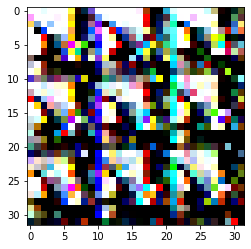

In [0]:
for i,f in enumerate(train_data):
  if i ==90:
    f = f[0]
    f = f.detach().numpy()
    f = np.reshape(f, (32,32,3))
    plt.imshow(f)
    plt.show()
    break
# this is because the values are normalized     

#### Trainloader

In [0]:
BS = 128
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BS, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
valid_loader = torch.utils.data.DataLoader(
    testset, batch_size=BS, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# test the conv layers and track the output for linear input

model = torch.nn.Sequential(
           nn.Conv2d(3, 64, 3),
           nn.MaxPool2d((2,2)),
           nn.BatchNorm2d(64),

           nn.Conv2d(64, 128, 5),
           nn.BatchNorm2d(128),

          nn.Conv2d(128, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.MaxPool2d((2,2)),

           nn.Conv2d(256, 512, 3),
           nn.BatchNorm2d(512),
           nn.MaxPool2d((2,2)),
           nn.Flatten()
)

x = trainset[0][0]
x = x.view(-1, 3, 32, 32)
t = model(x)
t.shape

torch.Size([1, 512])

Here 4608 is input for linear(Dense) layer

#### Model

In [0]:
class MakeModel(nn.Module):

  def __init__(self, in_features, out_features):

      super(MakeModel, self).__init__()

      self.layer1 = nn.Conv2d(3, 64, 3)
      torch.nn.init.kaiming_uniform_(self.layer1.weight)
      self.normalize1 = nn.BatchNorm2d(64)

      self.layer2 = nn.Conv2d(64, 128, 5)
      torch.nn.init.kaiming_uniform_(self.layer2.weight)
      self.normalize2 = nn.BatchNorm2d(128)

      self.layer3 = nn.Conv2d(128, 256, 3, padding=1)
      torch.nn.init.kaiming_uniform_(self.layer3.weight)
      self.normalize22 = nn.BatchNorm2d(256)

      self.layer4 = nn.Conv2d(256, 512, 3)
      torch.nn.init.kaiming_uniform_(self.layer4.weight)
      self.normalize3 = nn.BatchNorm2d(512)
      self.maxpool = nn.MaxPool2d((2,2))

      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(512, 256) # make sure it is less so image size is also less
      torch.nn.init.kaiming_uniform_(self.linear1.weight)

      self.dropout = nn.Dropout(p=0.2)
      self.linear2 = nn.Linear(256, 64)
      torch.nn.init.kaiming_uniform_(self.linear2.weight)

      self.linear3 = nn.Linear(64, out_features)
      self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

      x = x.view(-1, 3, 32, 32)
      x = self.layer1(x)
      x = nn.functional.leaky_relu(x, negative_slope=0.01)
      x = self.maxpool(x)
      x = self.normalize1(x)
      # x = self.dropout(x)
      
      x = self.layer2(x)
      x = nn.functional.leaky_relu(x, negative_slope=0.01)
      x = self.normalize2(x)
      # x = self.dropout(x)

      x = self.layer3(x)
      x = nn.functional.leaky_relu(x, negative_slope=0.01)
      x = self.normalize22(x)
      x = self.maxpool(x)
      # x = self.dropout(x)

      x = self.layer4(x)
      x = nn.functional.leaky_relu(x, negative_slope=0.01)
      x = self.normalize3(x)
      x = self.maxpool(x)

      x = self.flatten(x)
      x = self.linear1(x)
      x = nn.functional.leaky_relu(x, negative_slope=0.01)
      # x = self.dropout(x)

      x = self.linear2(x)
      x = nn.functional.leaky_relu(x, negative_slope=0.01)
      # x = self.dropout(x)
      
      x = self.linear3(x)
      x = self.softmax(x)

      return x
print("Okay")     

Okay


In [0]:
model = MakeModel(32,10).cuda(0)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", pytorch_total_params)

Total Trainable Parameters: 1832394


In [0]:
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
cost_function = torch.nn.CrossEntropyLoss()
TRAIN_STEP = len(trainset)/BS
VALID_STEP = len(testset)/BS

EPOCHS = 25 

In [0]:
# training

TRAIN_LOSS = []
VAL_LOSS = []
VAL_ACC = []

for epoch in range(EPOCHS):
  running_loss = 0.0

  for (x, y) in train_loader:
    model.train()
    optimizer.zero_grad()
    x, y = x.cuda(0), y.cuda(0)
    z = model(x)
    loss = cost_function(z, y)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  train_l = running_loss/TRAIN_STEP
  TRAIN_LOSS.append(train_l)
  total = 0
  correct = 0 
  print("Epoch", epoch+1)
  print("Training loss:", train_l) # current step size 390
  running_loss = 0.0

  for (x,y) in valid_loader:
    model.eval()
    x, y = x.cuda(0), y.cuda(0)
    z = model(x)
    loss = cost_function(z, y)
    running_loss+=loss.item()
    _, yhat = torch.max(z,1)
    total += y.size(0)
    correct += (yhat == y).sum().item()

  valid_l = running_loss/VALID_STEP
  valid_a = 100 * correct / total
  print("Valid loss:", valid_l) # current step size 78
  VAL_LOSS.append(valid_l)
  torch.cuda.empty_cache()
  print('VAL_Accuracy: %d %%' % valid_a)
  VAL_ACC.append(valid_a)

Epoch 1
Training loss: 2.054755193453569
Valid loss: 2.0014475889694996
VAL_Accuracy: 47 %
Epoch 2
Training loss: 1.9592266192803016
Valid loss: 1.9277144624636724
VAL_Accuracy: 55 %
Epoch 3
Training loss: 1.9187954269922696
Valid loss: 1.9092354193711891
VAL_Accuracy: 57 %
Epoch 4
Training loss: 1.8954520757381732
Valid loss: 1.8808193833400042
VAL_Accuracy: 60 %
Epoch 5
Training loss: 1.8780052848351307
Valid loss: 1.874732486712627
VAL_Accuracy: 60 %
Epoch 6
Training loss: 1.8616792553510422
Valid loss: 1.8434041769076617
VAL_Accuracy: 63 %
Epoch 7
Training loss: 1.8542399650964982
Valid loss: 1.835417553400382
VAL_Accuracy: 64 %
Epoch 8
Training loss: 1.8485703758704357
Valid loss: 1.8288792631564996
VAL_Accuracy: 65 %
Epoch 9
Training loss: 1.8337974823438203
Valid loss: 1.8139464610662215
VAL_Accuracy: 66 %
Epoch 10
Training loss: 1.8282035029851473
Valid loss: 1.8178065770711653
VAL_Accuracy: 66 %
Epoch 11
Training loss: 1.8259408177473606
Valid loss: 1.8216249041068249
VAL_Accu

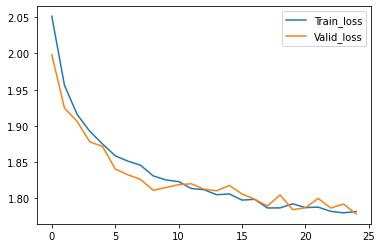

In [0]:
# draw graph for train and valid loss

a = np.arange(0,EPOCHS)
plt.plot(a, TRAIN_LOSS, label="Train_loss")
plt.plot(a, VAL_LOSS, label="Valid_loss")
plt.legend()
plt.show()

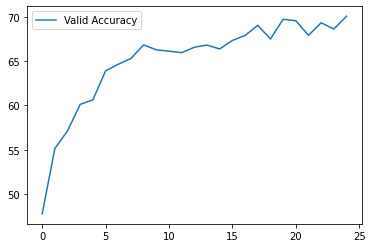

In [0]:
plt.plot(a, VAL_ACC, label="Valid Accuracy")
plt.legend()
plt.show()

In [0]:
show_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)

Files already downloaded and verified


Actual: 9, Predicted: 6


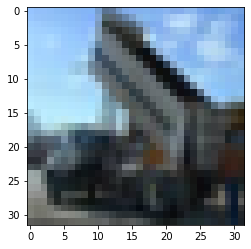

In [0]:
# plot test results

model.eval()
for i,(x,y) in enumerate(show_data):
  if i ==50:
    f = x
    f = np.reshape(f, (32,32,3))
    yhat = model(testset[i][0].cuda(0))
    print("Actual: {}, Predicted: {}".format(y, torch.argmax(yhat[0])))
    plt.imshow(f)
    plt.show()
    break